<a href="https://colab.research.google.com/github/YashvardhanDas/Enron-Analytics-JPMC/blob/main/Enron_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CHALLENGE 1: NLP

Enron Analytics:

This is a cleaned up version of a subset of the Enron emails. https://www.kaggle.com/loryn808/truncated-enron

Can you create data from the Enron emails for analysis?  Feel free to do any data  viz you think may be necessary.
Example:

How many emails were sent and received over a span of time (maybe on a per week or a per month bucket) for a particular email address?

What are the most commonly mentioned topic in the email body?  Topic could be a person, company/org, event,  significant noun phrases, etc.

The above are just suggestions.  Feel free to be creative. You can also extract other items from the emails that you think will be useful.

Can you think of use cases where this data might be useful?
Example:

Can you use this data set to predict who the possible email sender is?

Can you use this data set to classify an email to a certain topic?

The above are just suggestions.  Feel free to be creative.

#### **IMPORTING THE RELEVANT LIBRARIES**

In [53]:
#!pip install pandas --upgrade
!pip install pyLDAvis
!pip install pandasql
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pandasql import sqldf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### **CREATING DATAFRAME AND PANDASQL OBJECT**

In [55]:
pysqldf = lambda q: sqldf(q, globals())
df = pd.read_csv('enron_test.csv', parse_dates = ['Date'])
df.head()

,Date,From,To,Subject,content,new_date
0,2001-05-14 16:39:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,2001-05-04 13:51:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,2000-10-18 03:00:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,2000-10-23 06:13:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,2000-08-31 05:07:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


In [56]:
## Checking initial data types of the columns
df.dtypes

Date        object
From        object
To          object
Subject     object
content     object
new_date    object
dtype: object

In [57]:
## All values of 'Date' and 'new_date' are the same. So, we can drop the 'new_date' column

col1 = np.where(df["Date"] == df["new_date"], True, False)
(unique, counts) = np.unique(col1, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1000]])

In [58]:
df.drop('new_date', axis = 1, inplace = True)
df

,Date,From,To,Subject,content
0,2001-05-14 16:39:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n
1,2001-05-04 13:51:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...
2,2000-10-18 03:00:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!
3,2000-10-23 06:13:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31 05:07:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.
...,...,...,...,...,...
995,2001-03-19 01:36:00-08:00,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nStill trying to close the loop on ..."
996,2001-03-19 00:45:00-08:00,frozenset({'phillip.allen@enron.com'}),frozenset({'llewter@austin.rr.com'}),Re: Buyout,"Larrry,\n\nI realize you are disappointed abou..."
997,2000-12-06 08:04:00-08:00,frozenset({'phillip.allen@enron.com'}),frozenset({'pallen70@hotmail.com'}),NaN,---------------------- Forwarded by Phillip K ...
998,2001-03-16 04:28:00-08:00,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nI think we reached an agreement wi..."


#### **CONVERTING THE DATA TYPE OF 'DATE' COLUMN**

In [59]:
## Converting columns to 'Date' from object to date type

df['Date'] = pd.to_datetime(df['Date'],utc=True)
df.head()

,Date,From,To,Subject,content
0,2001-05-14 23:39:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n
1,2001-05-04 20:51:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...
2,2000-10-18 10:00:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!
3,2000-10-23 13:13:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31 12:07:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.


In [60]:
## Keeping only the date part from the datetime value in the 'Date' column

df['Date'] = df['Date'].dt.date
df

,Date,From,To,Subject,content
0,2001-05-14,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n
1,2001-05-04,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...
2,2000-10-18,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!
3,2000-10-23,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.
...,...,...,...,...,...
995,2001-03-19,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nStill trying to close the loop on ..."
996,2001-03-19,frozenset({'phillip.allen@enron.com'}),frozenset({'llewter@austin.rr.com'}),Re: Buyout,"Larrry,\n\nI realize you are disappointed abou..."
997,2000-12-06,frozenset({'phillip.allen@enron.com'}),frozenset({'pallen70@hotmail.com'}),NaN,---------------------- Forwarded by Phillip K ...
998,2001-03-16,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nI think we reached an agreement wi..."


In [61]:
## Recasting object type 'Date' column to date time from object

df['Date'] = pd.to_datetime(df['Date'])

In [62]:
## Rechecking data type of the columns

df.dtypes

Date       datetime64[ns]
From               object
To                 object
Subject            object
content            object
dtype: object

#### **USING REGEX TO FORMAT THE 'FROM' AND 'TO' COLUMNS**

In [63]:
## Removing frozenset characters from the 'From' and 'To' columns

df['From'] = df['From'].str.replace(r"frozenset|{|}|'","")
df['To'] = df['To'].str.replace(r"frozenset|{|}|'","")
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,Date,From,To,Subject,content
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),NaN,Here is our forecast\n\n
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.
...,...,...,...,...,...
995,2001-03-19,(phillip.allen@enron.com),(jacquestc@aol.com),NaN,"Jacques,\n\nStill trying to close the loop on ..."
996,2001-03-19,(phillip.allen@enron.com),(llewter@austin.rr.com),Re: Buyout,"Larrry,\n\nI realize you are disappointed abou..."
997,2000-12-06,(phillip.allen@enron.com),(pallen70@hotmail.com),NaN,---------------------- Forwarded by Phillip K ...
998,2001-03-16,(phillip.allen@enron.com),(jacquestc@aol.com),NaN,"Jacques,\n\nI think we reached an agreement wi..."


In [64]:
## Renaming column names

df.rename(columns={"From": "Sender", "To": "Receiver"}, inplace = True)

#### **ANALYZING COUNT OF EMAILS SENT WITH RESPECT TO EACH SENDER'S EMAIL ID.**

In [65]:
q2 = """SELECT SENDER, COUNT(*) AS SENDER_COUNT FROM df
GROUP BY 1
ORDER BY 2 DESC;"""

names2 = pysqldf(q2)
names2

,Sender,SENDER_COUNT
0,(phillip.allen@enron.com),946
1,(critical.notice@enron.com),5
2,(ina.rangel@enron.com),4
3,(announce@inbox.nytimes.com),2
4,(aod@newsdata.com),2
5,(ei_editor@ftenergy.com),2
6,(jsmith@austintx.com),2
7,(messenger@ecm.bloomberg.com),2
8,(sarah.novosel@enron.com),2
9,(webmaster@earnings.com),2


#### **MAJORITY OF THE EMAILS SENT ARE FROM THE EMAIL ID OF phillip.allen@enron.com**

In [66]:
## Analyzing count of emails for the Sender column for each user and each month

q = """SELECT strftime('%m', Date) AS Month , Sender, COUNT(*) AS Email_Count
       FROM df 
       GROUP BY 1, 2
       ORDER BY 1 ASC, 3 DESC;"""

names = pysqldf(q)
names

,Month,Sender,Email_Count
0,01,(phillip.allen@enron.com),79
1,01,(grensheltr@aol.com),1
2,01,(jfreeman@ssm.net),1
3,01,(matt@fastpacket.net),1
4,01,(owner-strawbale@crest.org),1
5,02,(phillip.allen@enron.com),98
6,02,(billc@greenbuilder.com),1
7,02,(calxa@aol.com),1
8,02,(ina.rangel@enron.com),1
9,02,(rob_tom@freenet.carleton.ca),1


#### **FOCUSING ON (phillip.allen@enron.com)'s SENT EMAILS FOR EACH YEAR AND VISUALISING THE SAME**

In [67]:

q = """SELECT strftime('%Y', Date) AS Year , Sender, COUNT(*) AS 'Number of Emails'
       FROM df 
       WHERE SENDER = '(phillip.allen@enron.com)'
       GROUP BY 1, 2
       ORDER BY 1 ASC, 3 DESC;"""

phillip_sent_year = pysqldf(q)
phillip_sent_year

,Year,Sender,Number of Emails
0,1980,(phillip.allen@enron.com),5
1,1999,(phillip.allen@enron.com),4
2,2000,(phillip.allen@enron.com),566
3,2001,(phillip.allen@enron.com),371


Text(0, 0.5, 'Emails per year \n')

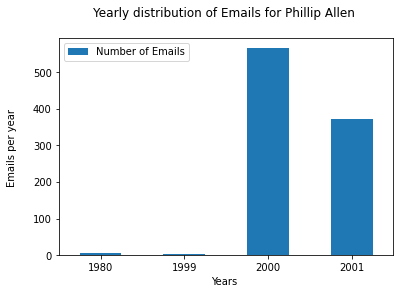

In [68]:
phillip_sent_year.plot.bar(x = 'Year', y ='Number of Emails', rot = 0)
plt.title('Yearly distribution of Emails for Phillip Allen \n')
plt.xlabel('Years \n')
plt.ylabel('Emails per year \n')

#### **MOST OF THE EMAILS (99%) WERE SENT IN THE YEARS OF 2000 AND 2001**

#### **FOCUSING ON (phillip.allen@enron.com)'s SENT EMAILS FOR EACH MONTH AND VISUALISING THE SAME**

In [69]:

q = """SELECT strftime('%m', Date) AS Month , Sender, COUNT(*) AS 'Number of Emails'
       FROM df 
       WHERE SENDER = '(phillip.allen@enron.com)'
       GROUP BY 1, 2
       ORDER BY 1 ASC;"""

phillip_sent_month = pysqldf(q)
phillip_sent_month

,Month,Sender,Number of Emails
0,01,(phillip.allen@enron.com),79
1,02,(phillip.allen@enron.com),98
2,03,(phillip.allen@enron.com),153
3,04,(phillip.allen@enron.com),152
4,05,(phillip.allen@enron.com),72
5,06,(phillip.allen@enron.com),38
6,07,(phillip.allen@enron.com),59
7,08,(phillip.allen@enron.com),101
8,09,(phillip.allen@enron.com),84
9,10,(phillip.allen@enron.com),45


Text(0, 0.5, 'Emails per month \n')

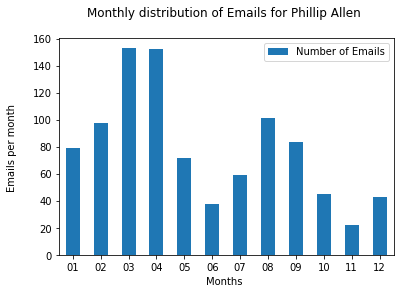

In [70]:
phillip_sent_month.plot.bar(x = 'Month', y ='Number of Emails', rot = 0)
plt.title('Monthly distribution of Emails for Phillip Allen \n')
plt.xlabel('Months \n')
plt.ylabel('Emails per month \n')

#### **A MAJOR CHUNK OF THE EMAILS WERE SENT IN THE MONTHS OF MARCH, APRIL AND THEN FOLLOWED BY AUGUST AND SEPTEMBER**

#### **ANALYZING COUNT OF EMAILS RECEIVED FOR EACH RECEIVERS'S EMAIL ID**

In [71]:
q2 = """SELECT RECEIVER, COUNT(*) AS RECEIVER_COUNT FROM df
GROUP BY 1
ORDER BY 2 DESC
LIMIT 20;"""

names2 = pysqldf(q2)
names2

,Receiver,RECEIVER_COUNT
0,(ina.rangel@enron.com),66
1,(jsmith@austintx.com),60
2,(stagecoachmama@hotmail.com),59
3,(pallen70@hotmail.com),42
4,(keith.holst@enron.com),37
5,(maryrichards7@hotmail.com),31
6,(john.lavorato@enron.com),26
7,(cbpres@austin.rr.com),22
8,(jacquestc@aol.com),22
9,(mike.grigsby@enron.com),19


#### **15 OF THE EMAIL IDs HAVE RECEIVED AT LEAST 10 EMAILS**

#### **FOCUSING ON THE TOP 5 EMAIL IDs FOR EACH YEAR, BASED ON THE NUMBER OF EMAILS RECEIVED**

In [72]:
q = """SELECT strftime('%Y', Date) AS Year, Receiver, COUNT(*) AS 'Number of Emails Received'
       FROM df 
       WHERE Receiver in ('(ina.rangel@enron.com)', '(jsmith@austintx.com)', '(stagecoachmama@hotmail.com)',
       '(pallen70@hotmail.com)', '(keith.holst@enron.com)')
       GROUP BY 1, 2
       ORDER BY 1, 2;"""

received_year = pysqldf(q)
received_year

,Year,Receiver,Number of Emails Received
0,1980,(jsmith@austintx.com),1
1,1999,(pallen70@hotmail.com),2
2,2000,(ina.rangel@enron.com),50
3,2000,(jsmith@austintx.com),27
4,2000,(keith.holst@enron.com),22
5,2000,(pallen70@hotmail.com),28
6,2000,(stagecoachmama@hotmail.com),39
7,2001,(ina.rangel@enron.com),16
8,2001,(jsmith@austintx.com),32
9,2001,(keith.holst@enron.com),15


In [73]:
## Number of emails received per year

received_year.groupby('Year')['Number of Emails Received'].sum()

Year
1980      1
1999      2
2000    166
2001     95
Name: Number of Emails Received, dtype: int64

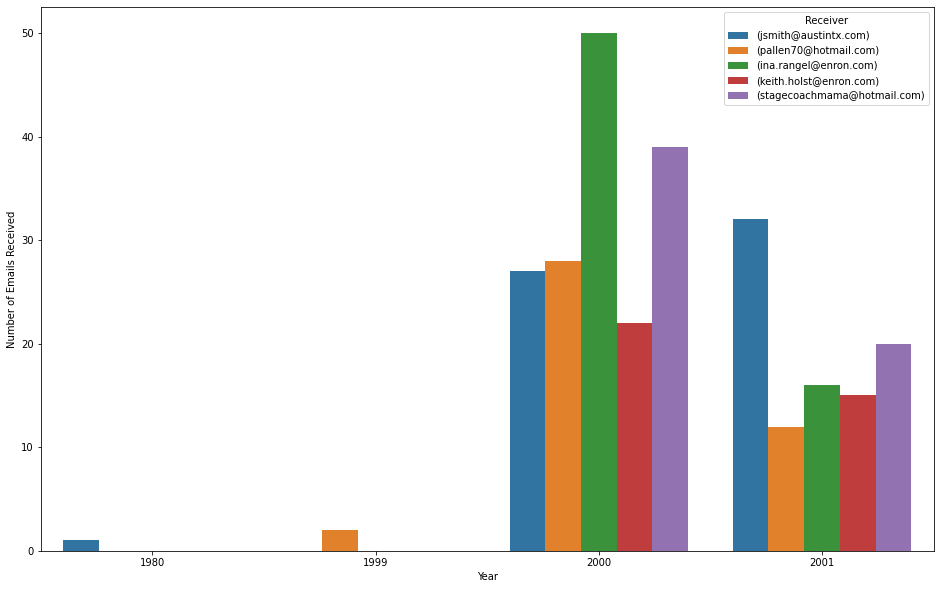

In [74]:
fig,ax = plt.subplots()
fig.set_size_inches(16,10)
sns.barplot(x='Year',y='Number of Emails Received',data = received_year, hue='Receiver')

#### **THE YEARS OF 2000 AND 2001 ACCOUNT FOR MOST OF THE RECEIVED EMAILS, WITH 165 EMAILS RECEIVED IN 2000 AND 95 RECEIVED IN 2001, WITH RESPECT TO THE TOP 5 EMAIL IDs**

#### **FOCUSING ON THE TOP 5 EMAIL IDs FOR EACH MONTH, BASED ON THE NUMBER OF EMAILS RECEIVED**

In [75]:
q = """SELECT strftime('%m', Date) AS Month , Receiver, COUNT(*) AS 'Number of Emails Received'
       FROM df 
       WHERE Receiver in ('(ina.rangel@enron.com)', '(jsmith@austintx.com)', '(stagecoachmama@hotmail.com)',
       '(pallen70@hotmail.com)', '(keith.holst@enron.com)')
       GROUP BY 1, 2
       ORDER BY 1, 2;"""

received_month = pysqldf(q)
received_month

,Month,Receiver,Number of Emails Received
0,01,(ina.rangel@enron.com),2
1,01,(jsmith@austintx.com),4
2,01,(keith.holst@enron.com),2
3,01,(pallen70@hotmail.com),5
4,01,(stagecoachmama@hotmail.com),6
5,02,(ina.rangel@enron.com),1
6,02,(jsmith@austintx.com),6
7,02,(keith.holst@enron.com),8
8,02,(pallen70@hotmail.com),6
9,02,(stagecoachmama@hotmail.com),7


In [76]:
## Number of emails received per month

received_month.groupby('Month')['Number of Emails Received'].sum()

Month
01    19
02    28
03    24
04    36
05    21
06    12
07    14
08    34
09    44
10    13
11     8
12    11
Name: Number of Emails Received, dtype: int64

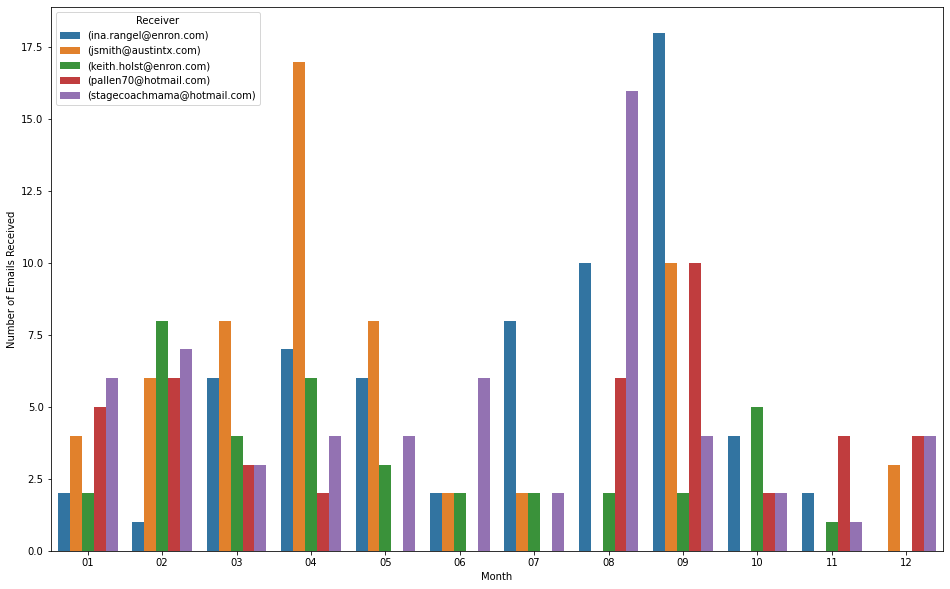

In [77]:
fig,ax = plt.subplots()
fig.set_size_inches(16,10)
sns.barplot(x='Month',y='Number of Emails Received',data = received_month, hue='Receiver')

#### **THE HIGHEST NUMBER OF EMAILS RECEIVED IN IN THE MONHT OF SEPTEMBER, FOLLOWED BY APRIL AND THEN AUGUST, WITH RESPECT TO THE TOP 5 EMAIL IDs.**

In [78]:
df.head(10)

,Date,Sender,Receiver,Subject,content
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),NaN,Here is our forecast\n\n
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.
5,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,"Greg,\n\n How about either next Tuesday or Thu..."
6,2000-08-22,(phillip.allen@enron.com),"(john.shafer@enron.com, david.l.johnson@enron....",NaN,Please cc the following distribution list with...
7,2000-07-14,(phillip.allen@enron.com),(joyce.teixeira@enron.com),Re: PRC review - phone calls,any morning between 10 and 11:30
8,2000-10-17,(phillip.allen@enron.com),(mark.scott@enron.com),Re: High Speed Internet Access,1. login: pallen pw: ke9davis\n\n I don't thi...
9,2000-10-16,(phillip.allen@enron.com),(zimam@enron.com),FW: fixed forward or other Collar floor gas pr...,---------------------- Forwarded by Phillip K ...


#### **ANALYZING THE SUBJECT OF THE EMAILS**

In [79]:
df['Subject'].isna().sum()

302

#### **IN 302 OF ALL THE EMAILS SENT, i.e, 30.2%, THERE IS NO SUBJECT MENTIONED.**

In [80]:
## Finding emails which are replies
reply_emails = df.loc[df['Subject'].str.contains("Re:", case=False, na=False)]
reply_emails

,Date,Sender,Receiver,Subject,content
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.
5,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,"Greg,\n\n How about either next Tuesday or Thu..."
7,2000-07-14,(phillip.allen@enron.com),(joyce.teixeira@enron.com),Re: PRC review - phone calls,any morning between 10 and 11:30
...,...,...,...,...,...
988,2001-03-26,(phillip.allen@enron.com),(stouchstone@natsource.com),Re:,"Steve,\n\nTry bmckay@enron.com or Brad.McKay@e..."
989,2001-03-26,(phillip.allen@enron.com),(llewter@austin.rr.com),Re: Buyout,"Larry,\n\nJacques has been working with Claudi..."
991,2001-03-19,(phillip.allen@enron.com),(jacquestc@aol.com),RE: Buyout,"Jacques,\n\nHere is Larry Lewter's response to..."
993,2001-03-19,(mark.whitt@enron.com),(jay.reitmeyer@enron.com),Re: Denver trading,"In regards to your E-mail, I have recently bee..."


#### **414 OF THE TOTAL 1000 EMAILS (41.4%) ARE REPLY EMAILS.**

In [81]:
### Analyzing context of the reply emails
reply_emails['Subject'].value_counts()


Re:                                                                                                          53
Re: Resume                                                                                                    7
Re: This morning's Commission meeting delayed                                                                 6
Re: The Stage                                                                                                 6
Re: (No Subject)                                                                                              5
                                                                                                             ..
Re: Associates & Analysts Eligible for Promotion                                                              1
Re: Draft of Opposition to ORA/TURN petition                                                                  1
Re: Response to PGE request for gas                                                                     

#### **OUT OF THE 414 REPLY EMAILS, 53 OF THESE (12.8%) DO NOT HAVE THE CONTEXT MENTIONED. 7 OF THE 414 REPLY EMAILS ARE CONCERNED ABOUT RESUME DISCUSSIONS.**

In [82]:
non_reply_emails = df.loc[~df['Subject'].str.contains("Re:", case=False, na=True)]
non_reply_emails

,Date,Sender,Receiver,Subject,content
9,2000-10-16,(phillip.allen@enron.com),(zimam@enron.com),FW: fixed forward or other Collar floor gas pr...,---------------------- Forwarded by Phillip K ...
12,2000-10-09,(phillip.allen@enron.com),(keith.holst@enron.com),Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...
13,2000-10-09,(phillip.allen@enron.com),(keith.holst@enron.com),Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...
16,2000-10-04,(phillip.allen@enron.com),(ina.rangel@enron.com),"Var, Reporting and Resources Meeting",---------------------- Forwarded by Phillip K ...
18,2000-10-03,(phillip.allen@enron.com),(pallen70@hotmail.com),Westgate,---------------------- Forwarded by Phillip K ...
...,...,...,...,...,...
975,2000-12-07,(tiffany.miller@enron.com),"(barry.tycholiz@enron.com, phillip.allen@enron...",System Development,Can you please review the following systems pr...
986,2000-12-07,(phillip.allen@enron.com),"(frank.ermis@enron.com, mike.grigsby@enron.com...",DJ Cal-ISO Pays $10M To Avoid Rolling Blackout...,---------------------- Forwarded by Phillip K ...
987,2001-03-26,(phillip.allen@enron.com),"(frank.ermis@enron.com, mike.grigsby@enron.com...",Current Gas Desk List,---------------------- Forwarded by Phillip K ...
994,2001-03-19,(phillip.allen@enron.com),(ina.rangel@enron.com),Your Approval is Overdue: Access Request for m...,"Ina,\n\nCan you help me approve this request?\..."


### **ABOUT 28.4% OF THE EMAILS, ARE NON-REPLY EMAILS, HAVING SOME SUBJECT MENTIONED.**

In [83]:
non_reply_emails['Subject'].value_counts()

Request from Steve Kean                                                     6
Westgate Proforma-Phillip Allen.xls                                         6
New Notice from Transwestern Pipeline Co.                                   5
Investment Structure                                                        5
Consolidated positions: Issues & To Do list                                 4
                                                                           ..
Highlights of Executive Summary by KPMG -- CPUC Audit Report on\n Edison    1
final business points                                                       1
Smeltering                                                                  1
Governor Reports Results of 1st RFP -- ONLY 500 MW!!!!                      1
System Development                                                          1
Name: Subject, Length: 161, dtype: int64

#### **OUT OF THESE EMAILS, THE SUBJECT PERTAINING TO STEVE KEAN's REQUEST ACCOUNTS FOR MOST FREQUENCY.**

#### **TOPIC MODELLING**

#### **TEXT CLEANING AND PREPROCESSING.**

In [84]:
import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [85]:
def clean_text(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [86]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
df['content'].dropna(axis = 0, how ='any',inplace=True)

In [88]:
df['content'] = df['content'].apply(clean_text)
df['Num_words_content'] = df['content'].apply(lambda x:len(str(x).split()))

In [89]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df['content']=df['content'].apply(remove_stopwords)

In [90]:
import en_core_web_sm
#nlp = en_core_web_sm.load()

In [91]:
nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [92]:
text_list=df['content'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

traveling business meeting takes trip especially prepare presentation would suggest holding business plan meetings take trip without formal business meetings would even honest opinions whether trip even desired necessary business meetings think would productive stimulate discussions across different groups working often presenter speaks others quiet waiting turn meetings might better held round table discussion format suggestion austin play golf rent boat skis flying somewhere takes much time
['business', 'meeting', 'trip', 'presentation', 'business', 'plan', 'meeting', 'trip', 'formal', 'business', 'meeting', 'honest', 'opinion', 'trip', 'necessary', 'business', 'meeting', 'stimulate', 'discussion', 'different', 'group', 'presenter', 'other', 'quiet', 'waiting', 'turn', 'meeting', 'round', 'table', 'discussion', 'format', 'suggestion', 'golf', 'boat', 'ski', 'much', 'time']


#### **APPLYING LATENT DIRICHLET ALLOCATION (LDA).**

In [93]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [94]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

#### **PRINTING WEIGHTAGE OF WORDS IN TOPICS.**

In [95]:
lda_model.print_topics()

[(0,
  '0.027*"power" + 0.017*"price" + 0.014*"utility" + 0.012*"basis" + 0.012*"plant" + 0.012*"bond" + 0.011*"state" + 0.010*"socal" + 0.010*"source" + 0.009*"rate"'),
 (1,
  '0.026*"project" + 0.026*"week" + 0.016*"property" + 0.016*"phillip" + 0.013*"email" + 0.012*"plan" + 0.011*"work" + 0.011*"market" + 0.011*"good" + 0.011*"site"'),
 (2,
  '0.043*"price" + 0.026*"meeting" + 0.018*"power" + 0.016*"trader" + 0.016*"trade" + 0.015*"index" + 0.014*"high" + 0.014*"physical" + 0.012*"date" + 0.010*"room"'),
 (3,
  '0.023*"call" + 0.019*"subject" + 0.016*"email" + 0.014*"information" + 0.013*"desk" + 0.012*"program" + 0.012*"team" + 0.012*"phillip" + 0.011*"analyst" + 0.011*"forwarded"'),
 (4,
  '0.040*"position" + 0.013*"deal" + 0.012*"manager" + 0.010*"trader" + 0.010*"issue" + 0.009*"ability" + 0.009*"project" + 0.009*"transport" + 0.008*"change" + 0.008*"time"'),
 (5,
  '0.049*"loan" + 0.035*"cost" + 0.022*"land" + 0.020*"construction" + 0.019*"unit" + 0.019*"09image" + 0.017*"impr

#### **VISUALISING THE TOP 10 TOPICS.**

In [96]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.305923  0.051779       1        1  14.962979
4      0.040894  0.092018       2        1  12.807197
2      0.112091  0.132755       3        1  12.294272
0      0.015301  0.136897       4        1  11.868462
1     -0.060026 -0.035483       5        1  11.315811
3      0.091398 -0.045663       6        1  11.172197
6      0.062645 -0.089580       7        1   7.413009
9     -0.086296 -0.139240       8        1   6.560392
7      0.077482 -0.153000       9        1   5.807475
8      0.052433  0.049517      10        1   5.798208, topic_info=            Term        Freq       Total Category  logprob  loglift
430         loan  240.000000  240.000000  Default  30.0000  30.0000
210     position  170.000000  170.000000  Default  29.0000  29.0000
92         price  285.000000  285.000000  Default  28.0000  28.0000
59          cost  216.000000  216.000000  Default  27.0000  27.0000
91         power  189.000000  189.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
24          time   10.707784  186.928315  Topic10  -5.0436  -0.0121
10       meeting    9.563596  173.691245  Topic10  -5.1566  -0.0517
238        total    9.194492   77.418338  Topic10  -5.1959   0.7170
277  information    9.187055  113.878991  Topic10  -5.1968   0.3303
154        daily    8.959588   65.317694  Topic10  -5.2218   0.8611

[671 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2845      1  0.959505       09go
2848      1  0.987462    09image
267      10  0.700874    12month
1622      8  0.918355       20th
309       3  0.874290        470
...     ...       ...        ...
111      10  0.128858       year
347       3  0.699192  yesterday
347       4  0.195774  yesterday
347       5  0.055935  yesterday
347       7  0.027968  yesterday

[1442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 1, 2, 4, 7, 10, 8, 9])

#### **ASSESSING PERFORMANCE OF LDA MODEL.**

In [97]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.32472371354413

Coherence Score:  0.33164464540115723


In [104]:
df.head(10)

,Date,Sender,Receiver,Subject,content,Num_words_content
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),NaN,forecast,2
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,traveling business meeting takes trip especial...,79
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful,2
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),NaN,randy send schedule salary level everyone sche...,18
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,lets shoot tuesday,3
5,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,greg either next tuesday thursday phillip,7
6,2000-08-22,(phillip.allen@enron.com),"(john.shafer@enron.com, david.l.johnson@enron....",NaN,please following distribution list updates phi...,26
7,2000-07-14,(phillip.allen@enron.com),(joyce.teixeira@enron.com),Re: PRC review - phone calls,morning,2
8,2000-10-17,(phillip.allen@enron.com),(mark.scott@enron.com),Re: High Speed Internet Access,login pallen ke9davis dont think required stat...,11
9,2000-10-16,(phillip.allen@enron.com),(zimam@enron.com),FW: fixed forward or other Collar floor gas pr...,forwarded phillip allenhouect buckner buck buc...,175


#### **POTENTIAL USE CASES OF THIS DATASET.**

##### **1. For marketing and product analytics domains, this dataset can be very useful in getting to know from/to which email ID the most email traffic flows.**

##### **2. As done with the topic modelling case in the case of content, the same can be applied to the subject of the email and in this way, we can get a better understanding of the reasons for the sent emails.**

##### **3. For predictive analytics purposes, we can maybe segregate the number of emails (sender/receiver) into fewer categories based on the highest frequencies. These can be used as the dependent variable which can be predicted via the columns of subject and content using different classification algorithms like Naive Bayes, Logistic Regression, etc. after appropriate NLP-based preprocessing techniques have been implemented like TF-IDF, Word2Vec.**